 **High-Frequency (Cypto price) trading rules using Machine Learning**
 
 Version 2.0
 
 Momentum strategy + Meta-Labeling


1. Financial Data and Bars 
 - OHLCV Bar
 - Summary and plot


2. Getting Trend Signals (Long only)
 - RSI with different windows


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with signals
 - Binary Labeling (Profit or Loss)


4. Secondary Model

 4.1. Features (X)
 - Market/ Microstructure features/ Fundamentals/ Sentiments/ 
 - Feature Scaling (MinMaxScaler)
 - Feature Engineering (PCA/ Autoencoder)
 
 4.2. Prediction Model
 - Simple Split
 - AutoML with *autogluon* and select the best model
 - Results
 
 4.2. Trading
 - Bet Sizing
 
 
5. Results
 - Cumulative returns, Sharpe Ratio, Drawdown


In [57]:
# De Prado AMFL
import triple_barrier as tb

# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.stats import norm, moment

#feature
from sklearn import preprocessing
from sklearn.decomposition import PCA 

# CV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

#ML
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import autogluon as ag

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

# DL
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import regularizers
from keras.utils.vis_utils import plot_model

# Technical analysis
import ta
import getTA #local
import tautil #local

# Backtesting pyfolio
import pyfolio as pf

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [28]:
def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    #plt.savefig('img/{}.png'.format(title))
    plt.show()

# 1. Financial Data and Bars

## OHLCV Bar

- ETH/USD 
- 5 minutes OHLCV(open, high, low, close, volume)

In [103]:
df_raw = pd.read_csv('ethusd5min.csv')
df = df_raw.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [104]:
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2020-04-10 00:00:00,169.56,169.72,169.41,169.43,2906.41820,1586477099999,4.930542e+05,707,2260.79119,3.835677e+05,0
2020-04-10 00:05:00,169.44,169.59,168.92,169.22,3376.45186,1586477399999,5.711061e+05,1004,1951.63764,3.301054e+05,0
2020-04-10 00:10:00,169.23,169.42,168.70,168.78,3007.20677,1586477699999,5.081008e+05,752,929.71120,1.571687e+05,0
2020-04-10 00:15:00,168.84,169.12,168.80,169.00,1465.81110,1586477999999,2.476386e+05,472,637.17163,1.076405e+05,0
2020-04-10 00:20:00,168.99,169.40,168.96,169.36,1067.16710,1586478299999,1.806507e+05,418,343.42918,5.811992e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09 23:40:00,2066.80,2069.36,2065.89,2067.74,696.35201,1618011899999,1.439804e+06,1078,350.52749,7.246912e+05,0
2021-04-09 23:45:00,2067.75,2070.85,2067.62,2070.42,1039.88778,1618012199999,2.152313e+06,1344,554.96546,1.148618e+06,0
2021-04-09 23:50:00,2070.42,2070.95,2069.05,2069.52,773.88383,1618012499999,1.601904e+06,1142,428.07969,8.860856e+05,0


In [5]:
# for faster calculating let's use shorter period.
#df = df.loc['2021-2':,:]

In [105]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [106]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume,buy_volume]).T
df_ohlcv.describe()

,open,high,low,close,volume,tb_base_av
count,104946.000000,104946.000000,104946.000000,104946.000000,104946.000000,104946.000000
mean,685.025957,686.504567,683.493090,685.042558,3389.883076,1686.291122
std,580.583410,581.997755,579.126169,580.594983,3942.126239,1986.441231
min,149.530000,150.240000,148.330000,149.530000,0.000000,0.000000
25%,241.600000,241.870000,241.312500,241.602500,1338.176817,643.987358
50%,393.615000,394.140000,393.050000,393.620000,2236.086545,1099.968845
75%,1108.187500,1112.172500,1103.345000,1108.187500,3894.748485,1946.347085
max,2146.440000,2151.000000,2142.460000,2146.550000,105591.963390,49449.316930


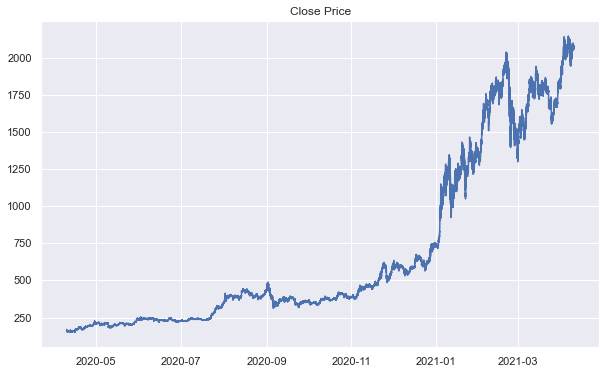

In [107]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('close_price.jpg')
plt.show();

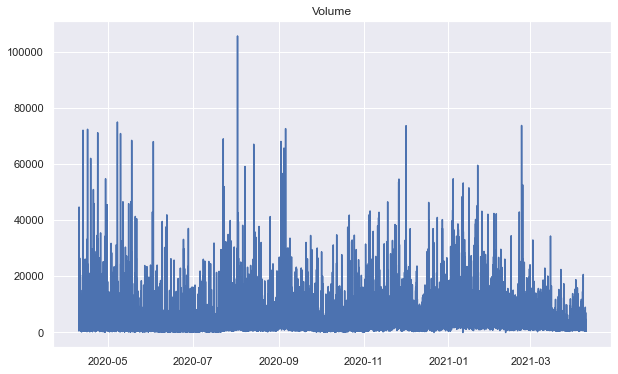

In [108]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('volume.jpg')
plt.show();

In [167]:
of = buy_volume - (volume-buy_volume)

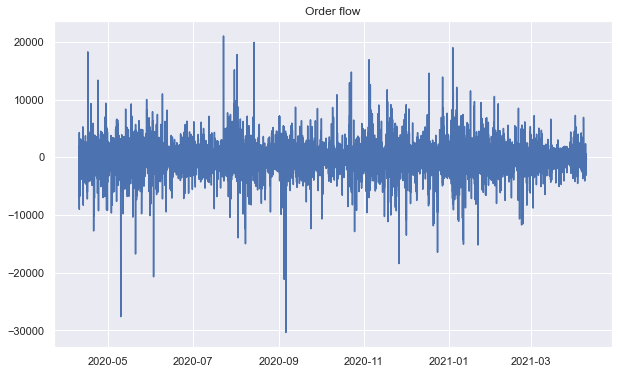

In [169]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('order_flow.jpg')
plt.show();

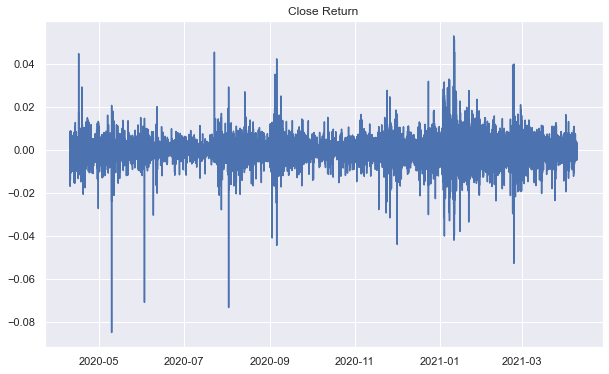

In [110]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('closereturn.jpg')
plt.show();

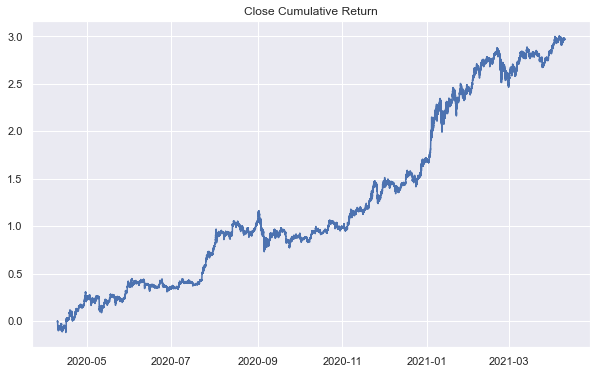

In [111]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.show();

# 2. Getting Trend Signals

 ## RSI method
 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

In [112]:
windows = np.arange(5,50,5)

In [113]:
rsi_df = pd.DataFrame(index=df.index)

In [114]:
for w in windows:
    rsi_df['rsi_{}'.format(w)] = tautil.my_rsi_2(close, w)
rsi_df.dropna(inplace=True)

In [115]:
rsi_df

,rsi_5,rsi_10,rsi_15,rsi_20,rsi_25,rsi_30,rsi_35,rsi_40,rsi_45
timestamp,,,,,,,,,
2020-04-10 03:50:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-04-10 03:55:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-04-10 04:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-04-10 04:05:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-04-10 04:10:00,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2021-04-09 16:20:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-04-09 23:00:00,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-04-09 23:05:00,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0


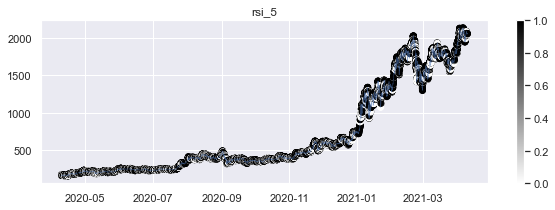

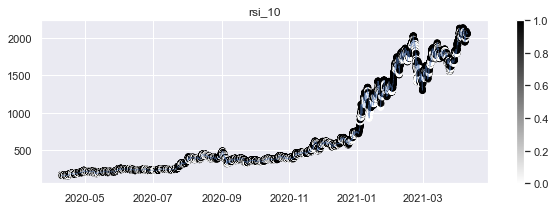

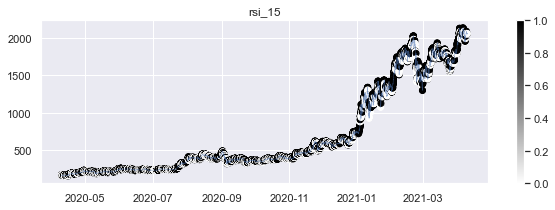

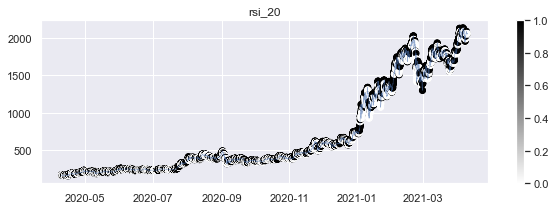

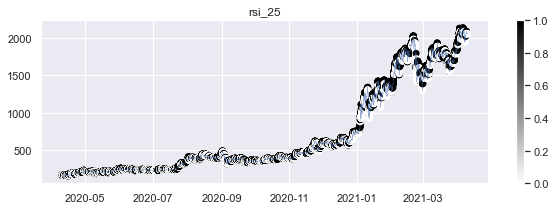

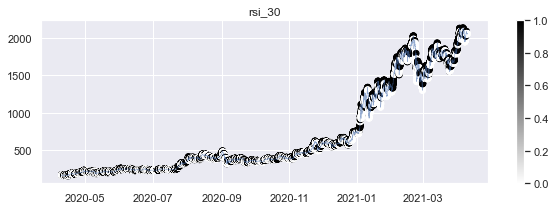

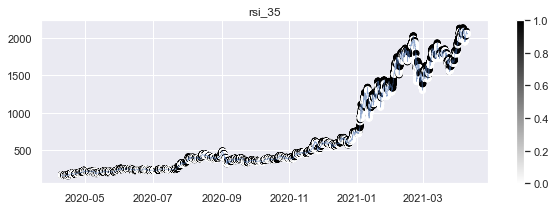

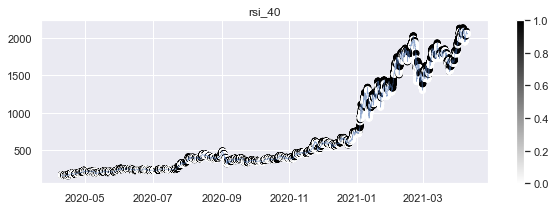

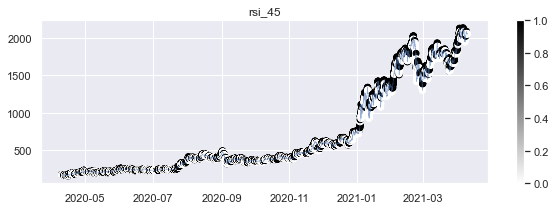

In [116]:
# long signals

for i in rsi_df.columns:
    sc = rsi_df[i].copy()
    plt.figure(figsize=(10,3))
    plt.plot(close.loc[sc.index], linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', alpha=1, vmin=0,vmax=1)
    plt.colorbar()
    plt.title('{}'.format(i))
    plt.show()

# 3. Labeling with Triple-Barrier Method
 ## Form Symmetric Triple Barrier with signals
 

In [117]:
#returns_df = pd.DataFrame()

#for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.05,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
#    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [118]:
#for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [119]:
#returns_df.cumsum()

I will choose rsi window = 10 for this asset and interval.

In [120]:
rsi_w = 'rsi_25'
long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
enter = long.index
pt_sl = [0.03,0.03] # profit-taking, stop-loss target
max_holding = [7,0] #[day,hours]
barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)

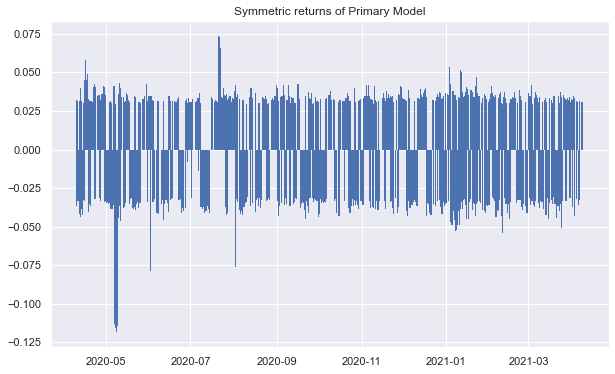

In [121]:
ret = barrier.ret
plt.figure(figsize=(10,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.show();

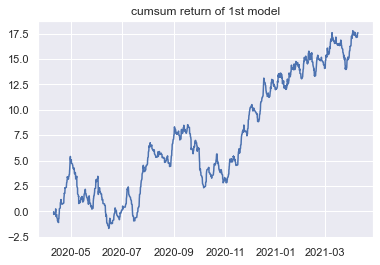

In [122]:
plt.figure()
plt.title('cumsum return of 1st model')
plt.plot(ret.cumsum())
plt.show()

## Binary Labeling (Profit or Loss)

In [123]:
first_model = pd.DataFrame()
first_model['y_pred'] = long
first_model['y_true'] = np.sign(long*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

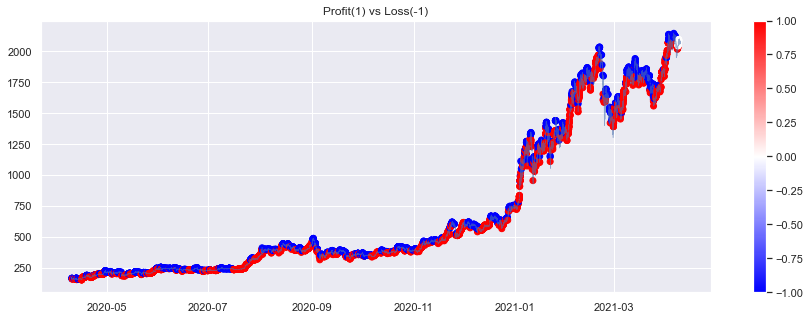

In [124]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [128]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

 1.0    2977
-1.0    2294
Name: y_true, dtype: int64

In [129]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.5647884651868715


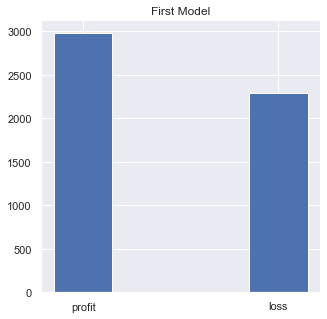

In [131]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.show()

# 4. Secondary Model

 ## 4.1. Features (X)
 ### - Market

Market
- Techincal indicators with market data

In [152]:
ohlcv = df.iloc[:,:5]
df_ = ohlcv

In [153]:
TA_ = getTA.get_ta(df_).dropna()
TA = TA_.drop(columns=['open','high','low'])

In [206]:
mkt = TA.copy()

for i in [1,5,12]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [10,40,80]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))
                   

corr = mkt.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,close,volume,m_rsi,m_roc,m_cmo,m_wr,vm_cmf,vm_mfi,vm_fi,vm_eom,vl_bbp,vl_atr,t_macdd,t_trix,t_cci,t_dpo,t_kst,t_adx,vol_mom_1,of_mom_1,mom_1,vol_mom_5,of_mom_5,mom_5,vol_mom_12,of_mom_12,mom_12,std_10,vol_std_10,std_40,vol_std_40,std_80,vol_std_80
close,1.00,0.09,0.02,0.01,0.02,0.03,-0.00,0.03,-0.01,0.00,0.02,0.78,0.00,0.02,0.02,-0.01,0.02,0.01,-0.00,0.00,0.01,-0.00,0.00,0.02,-0.00,0.00,0.02,0.65,-0.02,0.69,-0.04,0.71,-0.05
volume,0.09,1.00,-0.01,-0.07,-0.01,-0.01,0.06,-0.01,-0.19,-0.05,-0.03,0.36,-0.06,-0.04,-0.03,0.03,-0.03,0.28,0.38,-0.03,-0.03,0.52,-0.05,-0.07,0.57,-0.06,-0.08,0.47,0.68,0.36,0.52,0.32,0.45
m_rsi,0.02,-0.01,1.00,0.74,0.86,0.76,0.54,0.76,0.41,0.19,0.89,-0.03,0.43,0.56,0.87,-0.23,0.59,-0.04,-0.02,0.03,0.25,-0.02,0.09,0.47,-0.02,0.15,0.57,-0.03,-0.03,0.01,-0.00,0.01,0.01
m_roc,0.01,-0.07,0.74,1.00,0.78,0.64,0.44,0.65,0.65,0.18,0.69,-0.04,0.70,0.44,0.68,-0.52,0.48,-0.04,-0.02,0.01,0.24,-0.04,0.03,0.53,-0.10,0.23,0.85,-0.06,-0.09,-0.00,-0.01,-0.00,-0.01
m_cmo,0.02,-0.01,0.86,0.78,1.00,0.79,0.50,0.80,0.35,0.14,0.85,-0.02,0.52,0.36,0.83,-0.32,0.39,-0.02,-0.01,0.01,0.18,-0.02,0.04,0.39,-0.03,0.11,0.60,-0.02,-0.03,0.01,0.01,0.01,0.01
m_wr,0.03,-0.01,0.76,0.64,0.79,1.00,0.47,0.59,0.28,0.24,0.89,0.02,0.49,0.14,0.84,-0.27,0.17,0.02,-0.02,0.05,0.30,-0.03,0.12,0.48,-0.04,0.20,0.51,0.01,0.01,0.03,0.04,0.03,0.04
vm_cmf,-0.00,0.06,0.54,0.44,0.50,0.47,1.00,0.46,0.25,0.08,0.50,-0.01,0.29,0.32,0.50,-0.11,0.36,0.05,-0.01,0.01,0.12,-0.01,0.04,0.25,-0.01,0.06,0.36,-0.00,0.07,0.04,0.10,0.01,0.09
vm_mfi,0.03,-0.01,0.76,0.65,0.80,0.59,0.46,1.00,0.30,0.09,0.72,-0.01,0.42,0.41,0.72,-0.21,0.44,-0.05,-0.01,-0.02,0.10,-0.01,0.01,0.31,-0.01,0.04,0.49,-0.01,-0.03,0.02,0.00,0.01,0.00
vm_fi,-0.01,-0.19,0.41,0.65,0.35,0.28,0.25,0.30,1.00,0.24,0.34,-0.13,0.59,0.36,0.34,-0.30,0.38,-0.07,-0.04,0.02,0.33,-0.10,0.12,0.63,-0.12,0.19,0.69,-0.17,-0.15,-0.09,-0.09,-0.08,-0.07
vm_eom,0.00,-0.05,0.19,0.18,0.14,0.24,0.08,0.09,0.24,1.00,0.24,0.01,0.20,-0.01,0.21,-0.02,-0.00,0.00,-0.08,0.11,0.62,-0.05,0.17,0.42,-0.05,0.15,0.26,-0.00,-0.00,0.00,0.00,0.00,0.00


In [207]:
# Highly correlated market features

h = 0.8
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))
hc_list

array([['m_cmo', 'm_rsi'],
       ['m_cmo', 'm_rsi'],
       ['m_cmo', 't_cci'],
       ['m_cmo', 't_cci'],
       ['m_cmo', 'vl_bbp'],
       ['m_cmo', 'vl_bbp'],
       ['m_cmo', 'vm_mfi'],
       ['m_cmo', 'vm_mfi'],
       ['m_roc', 'mom_12'],
       ['m_roc', 'mom_12'],
       ['m_rsi', 't_cci'],
       ['m_rsi', 't_cci'],
       ['m_rsi', 'vl_bbp'],
       ['m_rsi', 'vl_bbp'],
       ['m_wr', 't_cci'],
       ['m_wr', 't_cci'],
       ['m_wr', 'vl_bbp'],
       ['m_wr', 'vl_bbp'],
       ['mom_12', 't_macdd'],
       ['mom_12', 't_macdd'],
       ['std_10', 'std_40'],
       ['std_10', 'std_40'],
       ['std_10', 'vl_atr'],
       ['std_10', 'vl_atr'],
       ['std_40', 'std_80'],
       ['std_40', 'std_80'],
       ['std_40', 'vl_atr'],
       ['std_40', 'vl_atr'],
       ['std_80', 'vl_atr'],
       ['std_80', 'vl_atr'],
       ['t_cci', 'vl_bbp'],
       ['t_cci', 'vl_bbp'],
       ['t_kst', 't_trix'],
       ['t_kst', 't_trix'],
       ['vol_std_40', 'vol_std_80'],
       ['

In [208]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['m_rsi', 'mom_12', 'std_40', 'std_80', 't_cci', 't_macdd',
       't_trix', 'vl_atr', 'vl_bbp', 'vm_mfi', 'vol_std_80'], dtype='<U10')

In [209]:
mkt1 = mkt.drop(columns=drop_features)
mkt1.corr()

,close,volume,m_roc,m_cmo,m_wr,vm_cmf,vm_fi,vm_eom,t_dpo,t_kst,...,of_mom_1,mom_1,vol_mom_5,of_mom_5,mom_5,vol_mom_12,of_mom_12,std_10,vol_std_10,vol_std_40
close,1.000000,0.091597,0.012605,0.017605,0.030911,-0.000142,-0.012470,0.002243,-0.007645,0.020968,...,0.000016,0.006954,-0.000508,0.000201,0.015763,-0.000639,0.000278,0.652213,-0.022106,-0.038011
volume,0.091597,1.000000,-0.074199,-0.014157,-0.006140,0.056675,-0.185746,-0.048453,0.030592,-0.031470,...,-0.027451,-0.032759,0.518128,-0.049476,-0.073163,0.565315,-0.059384,0.465007,0.676448,0.520259
m_roc,0.012605,-0.074199,1.000000,0.781031,0.643388,0.439890,0.649406,0.181946,-0.518152,0.480216,...,0.006856,0.236113,-0.039706,0.027410,0.531558,-0.102680,0.228352,-0.056039,-0.090577,-0.013795
m_cmo,0.017605,-0.014157,0.781031,1.000000,0.791044,0.496176,0.345787,0.144929,-0.319601,0.390757,...,0.012705,0.183794,-0.015740,0.042283,0.394082,-0.026323,0.110430,-0.019496,-0.033361,0.008569
m_wr,0.030911,-0.006140,0.643388,0.791044,1.000000,0.470749,0.281828,0.242851,-0.271031,0.166297,...,0.049897,0.300345,-0.028721,0.123717,0.480737,-0.039053,0.201616,0.014280,0.007569,0.041348
vm_cmf,-0.000142,0.056675,0.439890,0.496176,0.470749,1.000000,0.253844,0.084864,-0.113410,0.357775,...,0.014902,0.120525,-0.012968,0.043674,0.253107,-0.009404,0.063876,-0.003715,0.071858,0.100605
vm_fi,-0.012470,-0.185746,0.649406,0.345787,0.281828,0.253844,1.000000,0.244634,-0.300341,0.380205,...,0.022887,0.329206,-0.096598,0.116335,0.631951,-0.123515,0.188907,-0.165581,-0.149499,-0.094040
vm_eom,0.002243,-0.048453,0.181946,0.144929,0.242851,0.084864,0.244634,1.000000,-0.022160,-0.003314,...,0.111438,0.616365,-0.053687,0.167074,0.419735,-0.045128,0.154675,-0.001176,-0.001706,0.001563
t_dpo,-0.007645,0.030592,-0.518152,-0.319601,-0.271031,-0.113410,-0.300341,-0.022160,1.000000,-0.078917,...,0.015877,-0.020827,0.004343,0.070862,-0.208153,0.072889,-0.172413,0.031003,0.043020,0.004574
t_kst,0.020968,-0.031470,0.480216,0.390757,0.166297,0.357775,0.380205,-0.003314,-0.078917,1.000000,...,-0.016380,0.011983,0.013702,-0.070565,0.113393,0.004392,-0.107234,-0.090173,-0.078802,-0.060166


- Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

- Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

- Sentiment

Working on this.

## Feature Scaling

 
minmax

In [268]:
raw_X = mkt1.shift(1).dropna().copy()

scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X)
raw_X_scaled = scaler.transform(raw_X)

scaled_X = pd.DataFrame(raw_X_scaled,index=raw_X.index,columns=raw_X.columns)

## Feature Selection
- Autoencoder (in process)
- PCA

In [269]:
# PCA

#n=7
#pca = PCA(n)
#pca.fit(scaled_X)
#X_pca = pca.transform(scaled_X)

#pca_X = pd.DataFrame(X_pca, index=scaled_X.index)
#pca_X

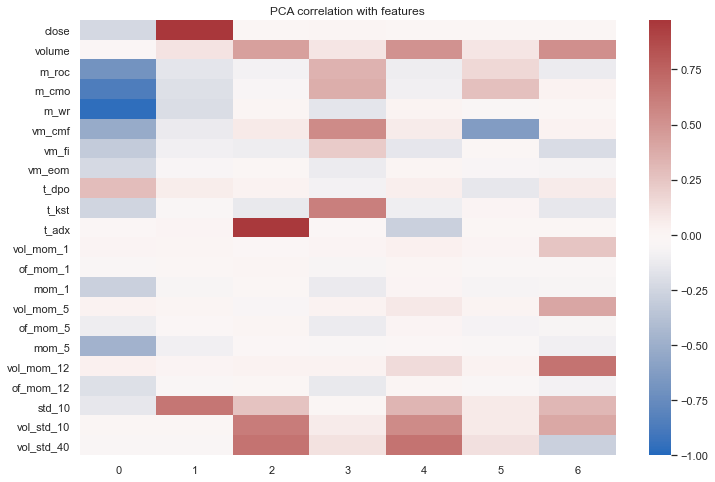

In [222]:
integrated_X = scaled_X.join(pca_X)
corr = integrated_X.corr().where(np.tril(np.ones(integrated_X.corr().shape)).astype(np.bool)).iloc[-n:,:-n].T
f = plt.figure(figsize=(12, 8))
sns.heatmap(corr,cmap='vlag',vmin=-1)
plt.title('PCA correlation with features')
plt.savefig('pcacorr.jpg')
plt.show();

# Machine Learning

In [270]:
y = pnllabel.copy().rename('y')

In [271]:
tmp_data = scaled_X.copy() # or pca_X
tmp_data = tmp_data.join(y)
tmp_data.dropna(inplace=True)

X2 = tmp_data.iloc[:,:-1]
y2 = tmp_data.iloc[:,-1]

In [272]:
train_data = tmp_data.loc[:'2021-1-1',:]
test_data = tmp_data.loc['2021-1-1':,:]

In [273]:
from autogluon.tabular import TabularPredictor

We have to focus on Precision score
because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

In [323]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20210714_140300\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210714_140300\"
AutoGluon Version:  0.2.0
Train Data Rows:    3684
Train Data Columns: 22
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [-1.0, 1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1.0, class 0 = -1.0
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1.0) vs negative (-1.0) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipe

[23:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.8294	 = Validation precision score
	1.14s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model: LightGBMLarge ...
	0.8732	 = Validation precision score
	1.78s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.8732	 = Validation precision score
	1.15s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 18.02s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20210714_140300\")


In [324]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,1.000000,0.873239,0.008976,0.004987,1.776350,0.008976,0.004987,1.776350,1,True,12
1,WeightedEnsemble_L2,1.000000,0.873239,0.016929,0.006982,2.929736,0.007954,0.001995,1.153386,2,True,13
2,XGBoost,1.000000,0.829431,0.047872,0.010971,1.141970,0.047872,0.010971,1.141970,1,True,11
3,LightGBM,0.750000,0.812500,0.008950,0.005984,1.874056,0.008950,0.005984,1.874056,1,True,4
4,NeuralNetFastAI,0.608527,0.657244,0.042886,0.016955,3.262959,0.042886,0.016955,3.262959,1,True,10
5,RandomForestEntr,0.581560,0.712644,0.131658,0.106613,0.848053,0.131658,0.106613,0.848053,1,True,6
6,CatBoost,0.575949,0.799373,0.004986,0.003990,1.629624,0.004986,0.003990,1.629624,1,True,7
7,RandomForestGini,0.563636,0.712209,0.134928,0.106685,0.670006,0.134928,0.106685,0.670006,1,True,5
8,KNeighborsDist,0.558233,0.627063,0.171967,0.135750,0.002990,0.171967,0.135750,0.002990,1,True,2
9,KNeighborsUnif,0.556000,0.620462,0.164808,0.137100,0.001995,0.164808,0.137100,0.001995,1,True,1


In [325]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data)

print("Predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: precision on test data: 1.0
Evaluations on test data:
{
    "precision": 1.0,
    "accuracy": 0.43243243243243246,
    "balanced_accuracy": 0.5011049723756906,
    "mcc": 0.03088807317514234,
    "f1": 0.004410143329658214,
    "recall": 0.0022099447513812156
}


Predictions:  
 timestamp
2021-01-01 02:15:00   -1.0
2021-01-01 02:45:00   -1.0
2021-01-01 18:40:00    1.0
2021-01-01 18:45:00    1.0
2021-01-02 06:50:00   -1.0
                      ... 
2021-04-08 08:10:00   -1.0
2021-04-08 08:15:00   -1.0
2021-04-08 08:20:00   -1.0
2021-04-08 13:50:00   -1.0
2021-04-08 14:00:00   -1.0
Name: y, Length: 1591, dtype: float64


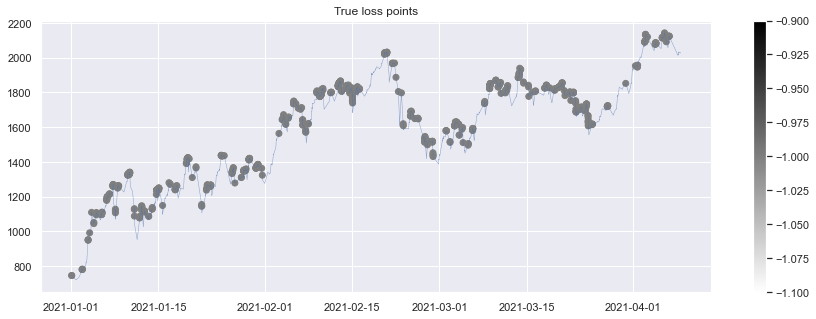

In [326]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

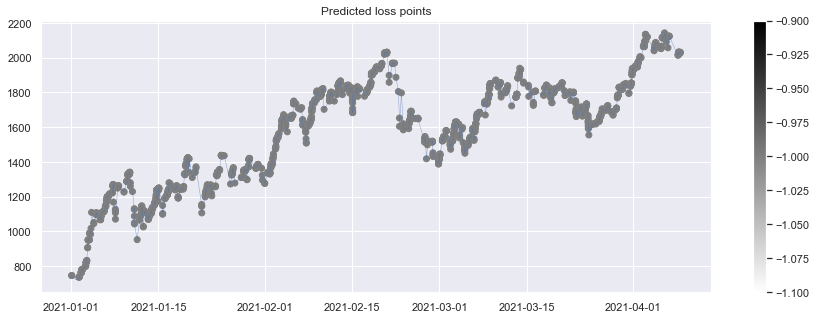

In [327]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [328]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

1.0    2
Name: y, dtype: int64

In [329]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())\

이익확률 pi:  1.0


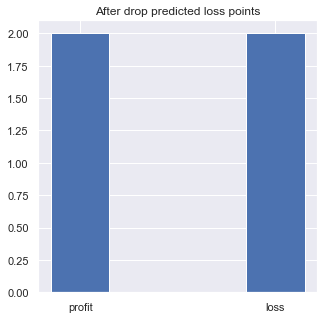

In [330]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.75

In [331]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

,-1.0,1.0
timestamp,,
2021-01-01 02:15:00,0.974633,0.025367
2021-01-01 02:45:00,0.974477,0.025523
2021-01-01 18:40:00,0.179789,0.820211
2021-01-01 18:45:00,0.091110,0.908890
2021-01-02 06:50:00,0.971793,0.028207
...,...,...
2021-04-08 08:10:00,0.784232,0.215768
2021-04-08 08:15:00,0.786747,0.213253
2021-04-08 08:20:00,0.857224,0.142776


In [332]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.75].index)
predlabel2.value_counts()

 1.0    87
-1.0    72
Name: y, dtype: int64

In [333]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())\

이익확률 pi:  0.5471698113207547


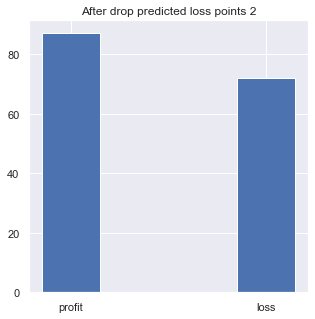

In [334]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.show()

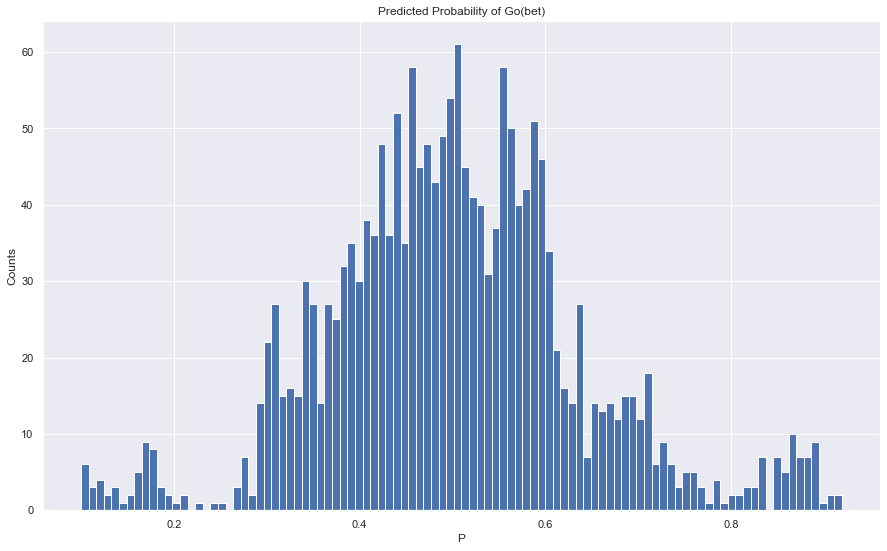

In [289]:
p = pd.Series(y_pred_prob)
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('Prob.jpg')
plt.show()

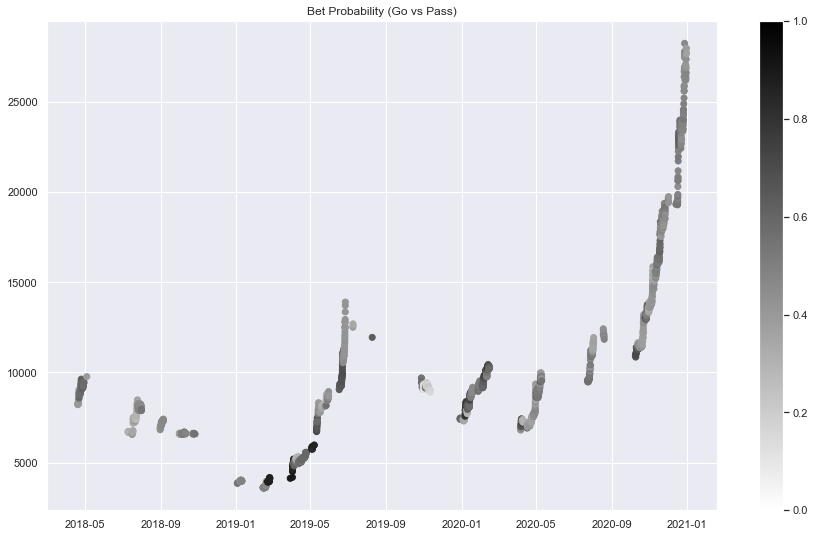

In [290]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y2.index, close.loc[y2.index] ,c= y_pred_prob, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.show()

## Bet Sizing

In [291]:
def get_signal(prob, num_classes, side=None):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    if not isinstance(side, type(None)):
        bet_sizes = side * (2 * norm.cdf(bet_sizes) - 1)
    else:
        bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [292]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [293]:
prob = pd.Series(y_pred_prob)
prob.index = y2.index

m = get_signal(prob, 2, side.loc[prob.index])

In [294]:
m2 = pd.Series(y_pred2,index=y2.index)*side.loc[prob.index]

Bet size scaling

In [295]:
mscaler = preprocessing.MinMaxScaler((0,1))
mscaler.fit(m.to_frame())
m_scaled = pd.DataFrame(mscaler.transform(m.to_frame()),columns=['m'],index=y2.index)
m_scaled

,m
timestamp,
2018-04-19 07:00:00,0.360764
2018-04-19 09:30:00,0.377520
2018-04-19 17:00:00,0.385051
2018-04-19 20:30:00,0.396958
2018-04-19 21:30:00,0.394618
...,...
2020-12-29 23:30:00,0.422790
2020-12-30 00:00:00,0.397369
2020-12-30 02:30:00,0.384235


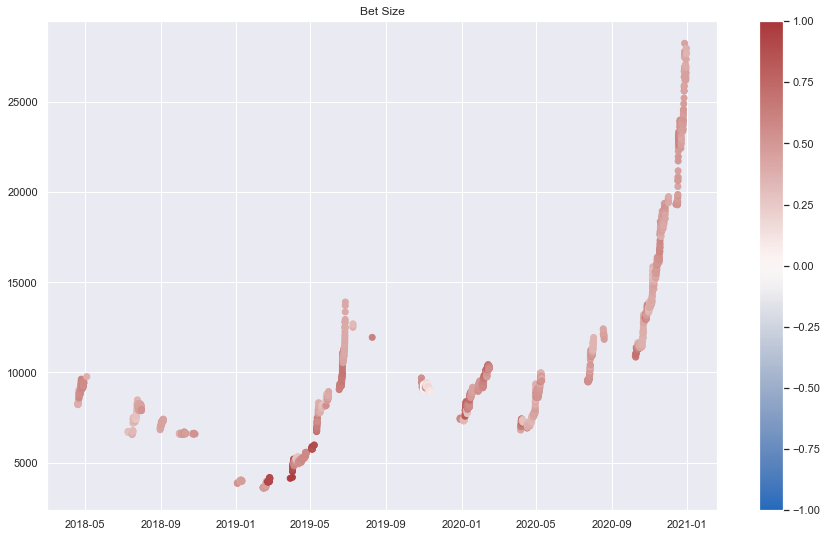

In [296]:
cmap = 'vlag'

plt.figure(figsize=(15,9))
plt.scatter(y2.index, close.loc[y2.index] ,c= m_scaled.m, cmap=cmap,vmin=-1,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('betsize.jpg')
plt.show()

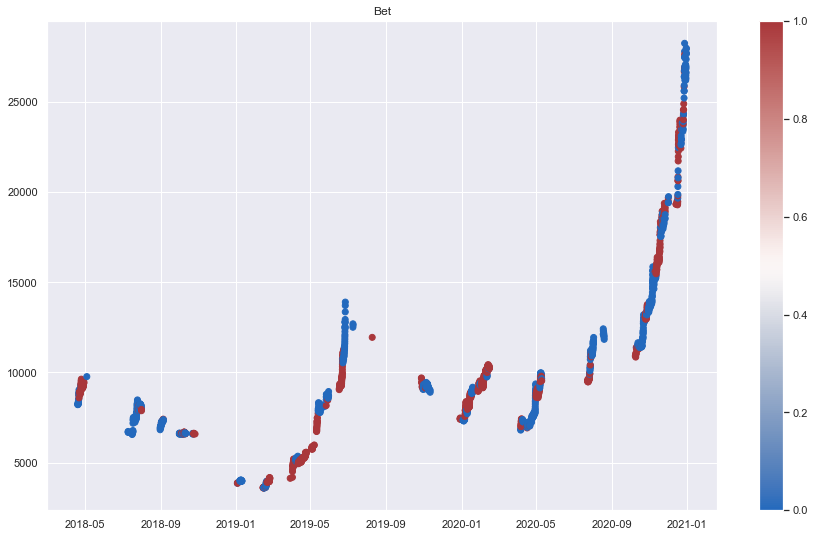

In [297]:
cmap = 'vlag'

plt.figure(figsize=(15,9))
plt.scatter(y2.index, close.loc[y2.index] ,c= m2, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet')
plt.savefig('betpred.jpg')
plt.show()

# Trading

In [301]:
# Trend Prediction
firstret = longret*side.loc[y2.index]
cumrfret = firstret.cumsum()

# After Meta-labeling
mlret = longret*m2
cummlret = mlret.cumsum()

# Bet sizing
bsret = longret*m_scaled.m
cumbsret = bsret.cumsum()

# Buy and Hold
buyholdret = (close.loc[y2.index][-1]-close.loc[y2.index][0])/close.loc[y2.index][0]
bh = pd.Series(0, index=y2.index)
bh.iloc[-1] = buyholdret

# Results

## Returns

In [302]:
dfret = pd.DataFrame({  'Trading Strategy':firstret,
                            'Meta-Label':mlret,
                           'Bet Sizing':bsret,
                     'Buy and Hold':bh})
dfret.describe()

,Trading Strategy,Meta-Label,Bet Sizing,Buy and Hold
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.006537,0.004266,0.003794,0.001303
std,0.035854,0.025496,0.018207,0.055606
min,-0.133955,-0.133955,-0.072111,0.000000
25%,-0.025199,0.000000,-0.010688,0.000000
50%,0.020364,0.000000,0.009497,0.000000
75%,0.032334,0.021207,0.015515,0.000000
max,0.080413,0.080413,0.073650,2.372883


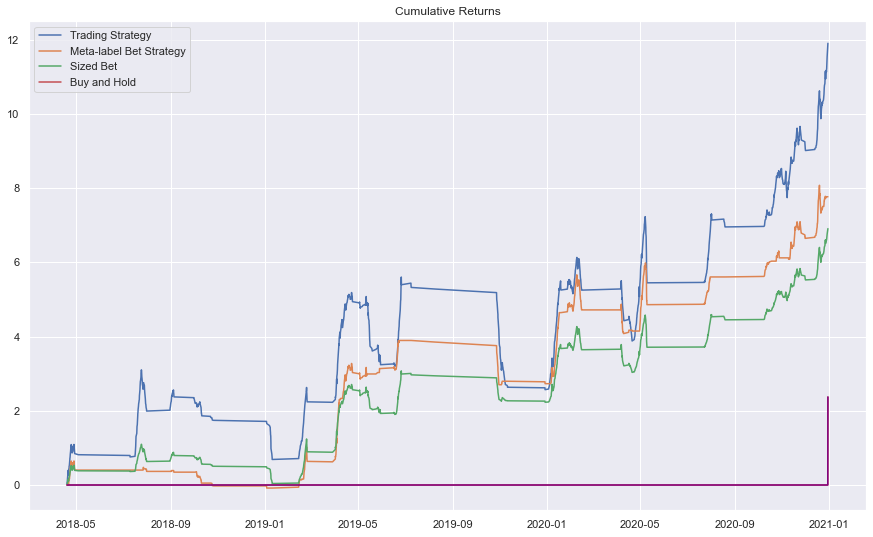

In [303]:
plotcumret = pd.DataFrame({'Trading Strategy':cumrfret,
                           'Meta-label Bet Strategy':cummlret,
                           'Sized Bet':cumbsret,
                           'Buy and Hold':bh})

plt.figure(figsize=(15,9))
plt.title('Cumulative Returns')
plt.plot(plotcumret)


# Purple line is buy and hold
plt.plot(bh ,color='purple')
plt.legend(plotcumret)
plt.savefig('cumret.jpg')
plt.show()

In [304]:
def sr(df):
    out = pd.DataFrame(index=['Annualized Sharpe Ratio'])
    for c in df.columns:
        out[c] = (df[c].mean()/df[c].std())*((mt*365)**0.5)
    return out

In [305]:
sr(dfret)

,Trading Strategy,Meta-Label,Bet Sizing,Buy and Hold
Annualized Sharpe Ratio,24.131118,22.144476,27.58122,3.101788
